# Machine Learning Projet : Stock Return Prediction

Axel PORTIER, Lucas STALTER, Gaspard SALLURON--BESNARD

# Project Overview

This project aims to predict the direction of residual stock returns in the U.S. market using historical financial data from Qube RT. The goal is to detect weak predictive signals rather than forecast exact prices, focusing on the underlying patterns that drive short-term stock movements once market effects are removed.

The dataset includes 46 numerical features, covering anonymized identifiers (STOCK, INDUSTRY, SECTOR) and 20-day histories of residual returns (RET_1–RET_20) and trading volumes (VOLUME_1–VOLUME_20). The target variable, RET, is binary, indicating whether the residual return at time t is positive or negative.

Following a structured machine learning pipeline, we perform data quality checks, feature preprocessing, and correlation analysis, then train both baseline models (e.g., Logistic Regression, Decision Trees) and advanced algorithms (e.g., Random Forest, XGBoost, Neural Networks). Model performance is assessed using F1-score and ROC-AUC, ensuring robust evaluation despite potential class imbalance.

Ultimately, this work explores how machine learning methods can capture meaningful financial patterns to support better decision-making in quantitative trading and risk management.

In [39]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Phase I QUALITY CHECK & DATA EXPLORATION

The dataset consists of 46 descriptive features, all represented as numerical values (float or integer).

- `DATE` : an anonymized and randomized date index, without temporal continuity or sequential dependency.

- `STOCK` : an identifier representing the stock.

- `INDUSTRY`, `INDUSTRY_GROUP`, `SUB_INDUSTRY`, `SECTOR`: hierarchical categorical indices describing the economic domain of each stock (e.g., aeronautics, IT, oil, etc.).

- `RET_1` to `RET_20`: historical residual returns over the last 20 days, where `RET_1` corresponds to the previous day’s residual return, `RET_2` to two days before, and so on.

- `VOLUME_1` to `VOLUME_20`: historical relative trading volumes over the last 20 days, where `VOLUME_1` is the volume of the previous day.

The target variable, `RET`, is binary and represents the sign of the residual stock return at time t (i.e., positive or negative).

In the initial phase, the analysis focuses on understanding the dataset’s structure — specifically investigating missing values, class balance, and potential correlations among features.

### In the dataset we must acknowledge this : SUB INDUSTRY ⊂ INDUSTRY ⊂ INDUSTRY_GROUP ⊂ SECTOR 

## I) Data Loading & Initial Verification

In [40]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1) #axis = 1 concat by columns
test = pd.read_csv('./x_test.csv', index_col='ID')
print(train.columns)
train.head()

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET'],
      dtype='object')


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


### Dataset features's types

In [ ]:
train.info()
train.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

float64    40
int64       6
bool        1
Name: count, dtype: int64

### Type of the target

In [42]:
print(train['RET'].value_counts(normalize=True))
print(train['RET'].dtype)


RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64
bool


The target variable `RET` is well balanced, with approximately 50.1% False and 49.9% True values, indicating no significant class imbalance in the dataset. However, to experiment with different approaches, we will still address the imbalance problem later in the project.

### Dataset's dimensions :

In [43]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()
train.describe(include='all')

Train shape: (418595, 47)
Test shape: (198429, 46)


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000,418595
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209749
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337,NaN
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928,NaN
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790,NaN
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405,NaN
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795,NaN


# II) Data Processing

### From now on, we are gonna work on the train by the intermediary of the ***cleaning_train*** dataset in order to clearly seperate both

For simplicity and computational efficiency in testing and throughout the rest of the project, we will focus on **the last 10 days** of returns and volumes.

In [44]:
to_drop = [f'RET_{day}' for day in range(11,21)]
to_drop += [f'VOLUME_{day}' for day in range(11,21)]
cleaning_train = train.drop(columns= to_drop).copy()

## II.1) Missing values analysis

In [45]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET_6              0.620409
VOLUME_6          17.848756
RET_7              0.617542
VOLUME_7          17.643068
RET_8              0.626620
VOLUME_8          17.653818
RET_9              0.640715
VOLUME_9          17.510481
RET_10             0.643104
VOLUME_10         17.512154
RET                0.000000
dtype: float64

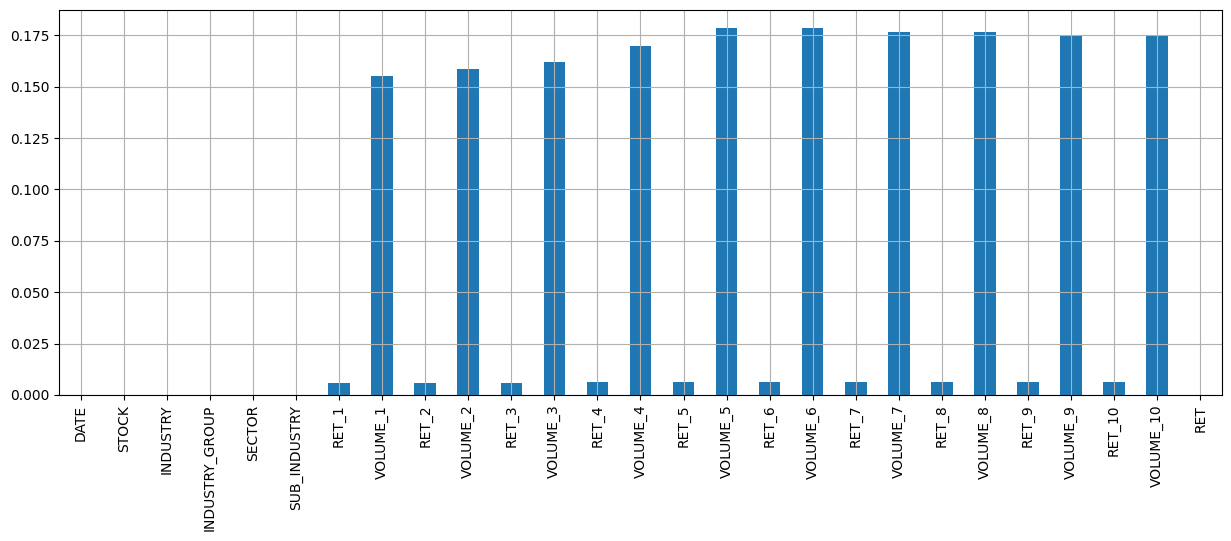

In [46]:
nb_missing = cleaning_train.isna().sum()
rate_missing = nb_missing / cleaning_train.index.nunique()

fig, ax = plt.subplots(figsize=(15,5))
rate_missing.plot(kind="bar", ax=ax)

ax.grid()
plt.xticks(rotation=90)
plt.show()


Most of the missing values are concentrated in the `VOLUME_1`..., with around **15% missing data**, which represents a considerable proportion. 
Consequently, a specific step will be devoted later to addressing these missing values.
It is also import to hightlight that there is no missing values in the `SECTOR` etc.

### Percentage of missing values for each unique value within  `INDUSTRY`, `INDUSTRY_GROUP`, `SECTOR`, `SUB_INDUSTRY`, `STOCK`, and `DATE`.

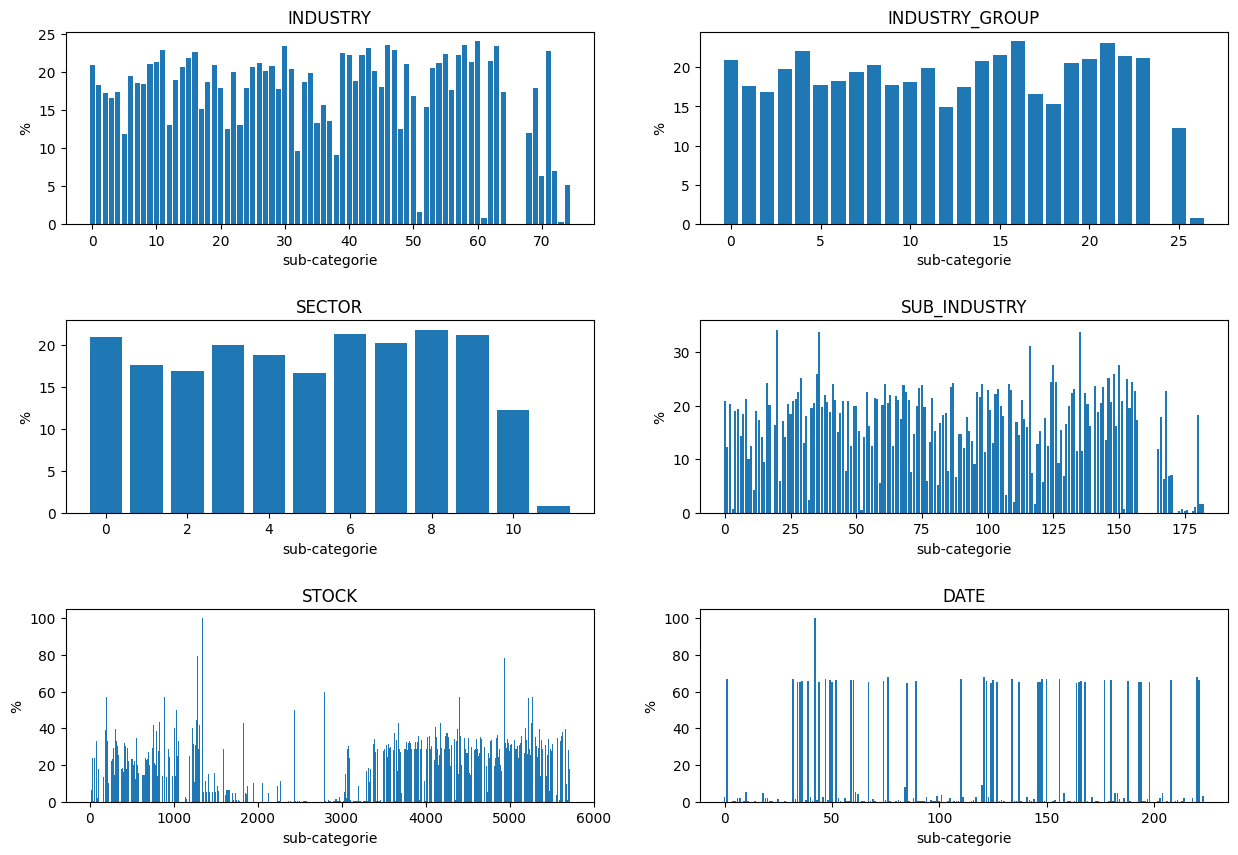

In [47]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    X_absciss = cleaning_train[categorie].sort_values().unique()

    unique_Y_values = cleaning_train[categorie].sort_values().unique()
    Y_absciss = [(cleaning_train[cleaning_train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(cleaning_train[cleaning_train[categorie]==sub_categorie])*100 for sub_categorie in unique_Y_values]
    
    plt.bar(X_absciss,Y_absciss)
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()

The plots display the percentage of NaN values per subcategory. We observe a relatively even distribution of missing values for the categorical variable SECTOR, whereas the amount of missing data in other categorical features appears less uniform.

It may be useful to investigate whether some rows mainly consist of missing values in the descriptive variables (RET and VOLUME). If that is the case, those observations can reasonably be removed, as they do not contribute meaningful information to the model.

We will first **remove rows with heavy missingness**, then **impute minor gaps** with consistent values.

### Let's remove the rows where half or more of their features `RET_` and `VOL_` are NaN

In [48]:
ret_features = [f'RET_{day}' for day in range(1,11)]
vol_features = [f'VOLUME_{day}' for day in range(1,11)]
features = vol_features + ret_features

to_drop = cleaning_train[cleaning_train[features].isna().sum(axis=1) >= len(features)*0.5][features].index
nb_drop = len(to_drop)
nb_rows = len(cleaning_train)
print(
    f"Number of rows before removing: {nb_rows}\n"
    f"Number of rows removed: {nb_drop}\n"
    f"Overall ratio (% of rows removed): {nb_drop / nb_rows * 100:.4f}%"
)


cleaning_train.drop(index = to_drop, axis=0, inplace = True)

Number of rows before removing: 418595
Number of rows removed: 54607
Overall ratio (% of rows removed): 13.0453%


About 13% of the rows were less than half complete, which is a significant proportion and an important aspect to take into account during data cleaning.

In [49]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE              0.000000
STOCK             0.000000
INDUSTRY          0.000000
INDUSTRY_GROUP    0.000000
SECTOR            0.000000
SUB_INDUSTRY      0.000000
RET_1             0.001923
VOLUME_1          2.862182
RET_2             0.002747
VOLUME_2          3.236096
RET_3             0.001923
VOLUME_3          3.629790
RET_4             0.001374
VOLUME_4          4.502896
RET_5             0.000824
VOLUME_5          5.518589
RET_6             0.000549
VOLUME_6          5.524633
RET_7             0.000000
VOLUME_7          5.287812
RET_8             0.000000
VOLUME_8          5.300449
RET_9             0.000000
VOLUME_9          5.136983
RET_10            0.000275
VOLUME_10         5.139730
RET               0.000000
dtype: float64

From now on the stat of missing values are lower, but let's keep digging that way by replacing the missing values

### Before that let's have a look at the features distributions

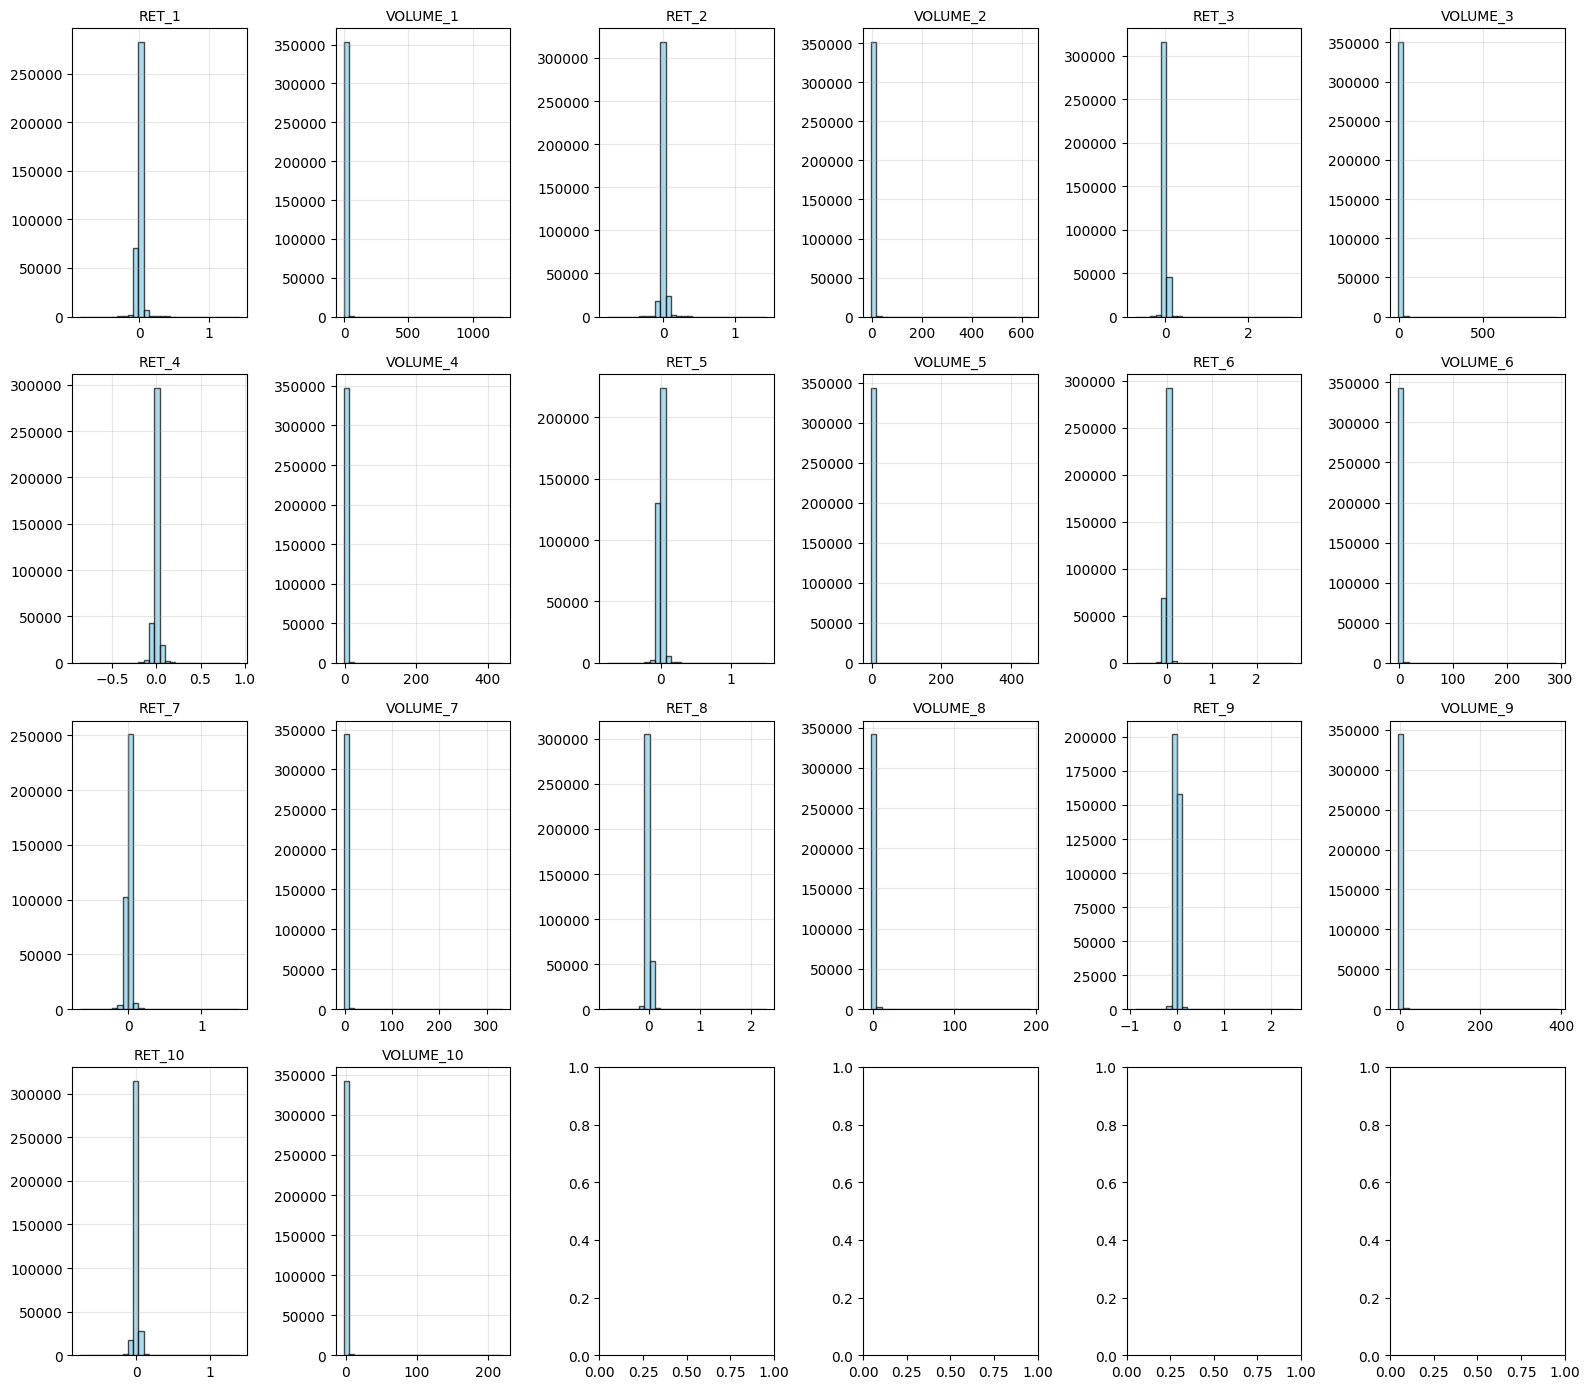

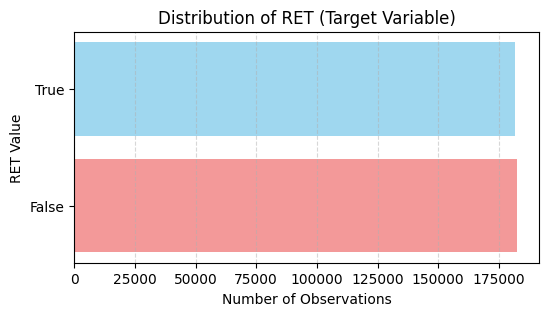

In [50]:
features = [col for col in cleaning_train.columns if col not in ["INDUSTRY", "INDUSTRY_GROUP", "SECTOR", "SUB_INDUSTRY", "STOCK", "DATE","RET"]]
n_cols = 6
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    cleaning_train[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(feature, fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

ret_counts = cleaning_train["RET"].value_counts()
plt.figure(figsize=(6, 3))
plt.barh(ret_counts.index.astype(str), ret_counts.values, color=["lightcoral", "skyblue"], alpha=0.8)
plt.title("Distribution of RET (Target Variable)")
plt.xlabel("Number of Observations")
plt.ylabel("RET Value")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


The plots are not very meaningful since most values are centered around 0. This is consistent with the nature of the data: we are dealing with relative volumes and residual returns, which are either normalized or expressed relative to market behavior after removing overall market effects. Nevertheless, it is interesting to note that the RET values are fairly well balanced.

In [51]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,11):
    volume.loc[day] =[day, cleaning_train[f'RET_{day}'].mean(), cleaning_train[f'RET_{day}'].median(), cleaning_train[f'RET_{day}'].std(), 
                      cleaning_train[f'VOLUME_{day}'].mean(), cleaning_train[f'VOLUME_{day}'].median(), cleaning_train[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001656,0.000814,0.030582,-0.071502,-0.282609,3.038658
2,2.0,0.001353,0.000876,0.030159,-0.075230,-0.278437,2.635549
3,3.0,0.002575,0.001251,0.030920,-0.097235,-0.278277,2.490831
4,4.0,-0.001089,-0.000636,0.029817,-0.088976,-0.275435,1.730786
5,5.0,0.000765,0.000000,0.031250,-0.092162,-0.281238,1.848980
6,6.0,-0.000166,0.000000,0.030534,-0.100509,-0.288125,1.689070
7,7.0,0.000240,0.000000,0.030233,-0.084719,-0.284789,1.839735
8,8.0,-0.000407,-0.000446,0.030708,-0.087038,-0.289772,1.595810
9,9.0,-0.000891,-0.000233,0.032157,-0.090856,-0.298185,1.857252
10,10.0,0.000397,0.000000,0.030469,-0.092194,-0.295754,1.653336


### Missing Value Imputation Choice for `VOL_`

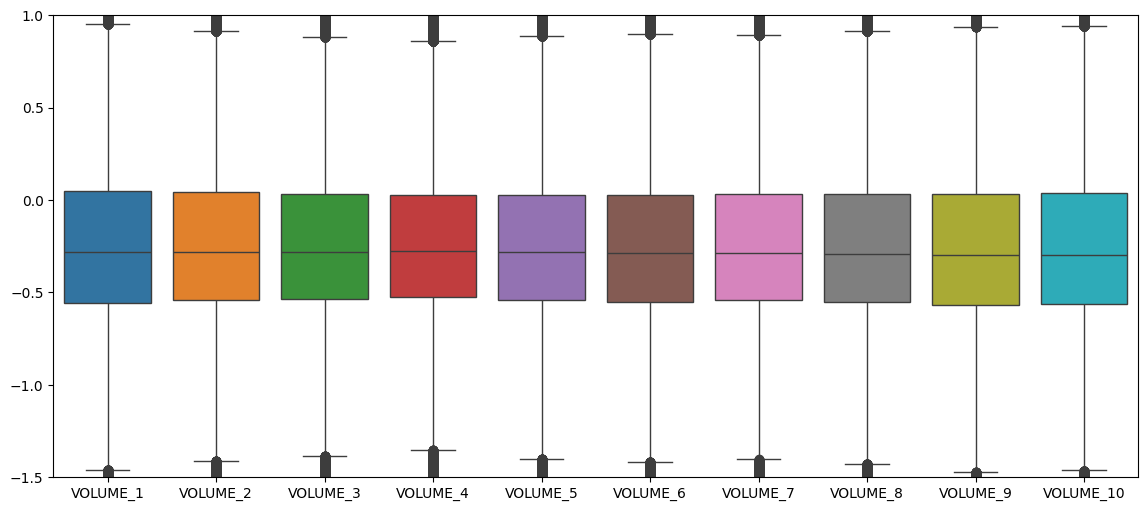

In [52]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'VOLUME_{day}' for day in range(1,11)]])
plt.ylim((-1.5,1))
plt.show()

### Justification for Missing-Value Imputation (Volumes)

**A quick reminder — what is skewness?**  
Skewness describes the *asymmetry* of a distribution:  
- **Symmetric**: left and right tails are similar; mean ≈ median.  
- **Left-skewed (negative skew)**: longer/larger tail on the left; **mean < median**.  
- **Right-skewed (positive skew)**: longer/larger tail on the right; **mean > median**.  

**What we observe for `VOLUME_1`–`VOLUME_10`:**  
- The **median is around −0.25** across all volume features (i.e., slightly shifted left, not centered at 0, and showing **no extreme skew**).  
- Outliers exist but are not dominant, and we will handle them later.  

**Why we impute with the median:**  
- The **median is robust** to outliers, unlike the mean, which is affected by them.  
- Therefore, based on our boxplots, imputing with the **mean** would be too optimistic and could distort the true distribution.



In [53]:
per_feature_median_volume = cleaning_train[vol_features].median()
print(per_feature_median_volume)
cleaning_train[vol_features] = cleaning_train[vol_features].fillna(per_feature_median_volume)


VOLUME_1    -0.282609
VOLUME_2    -0.278437
VOLUME_3    -0.278277
VOLUME_4    -0.275435
VOLUME_5    -0.281238
VOLUME_6    -0.288125
VOLUME_7    -0.284789
VOLUME_8    -0.289772
VOLUME_9    -0.298185
VOLUME_10   -0.295754
dtype: float64


### Missing Value Imputation Choice for `RET_`

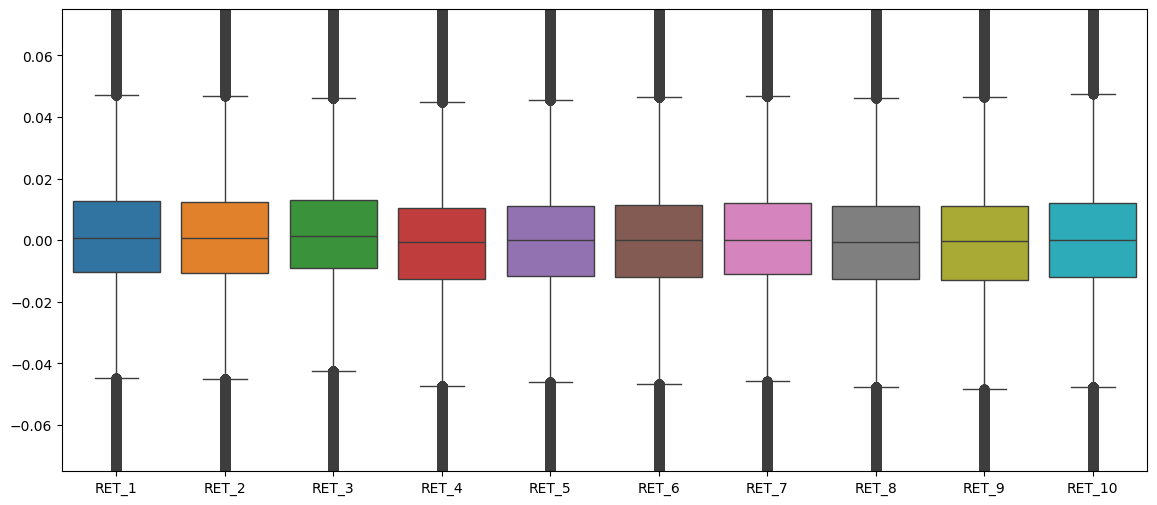

In [54]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'RET_{day}' for day in range(1,11)]])
plt.ylim((-0.075,0.075))
plt.show()

For the `RET_` features, the **median is close to 0**, indicating a symmetric distribution around the center.  
Although imputing missing values with the **mean** could be appropriate in this case, we will use the **median** instead to remain consistent with a **robust imputation strategy** less sensitive to potential outliers.


In [55]:
per_feature_median_return  = cleaning_train[ret_features].median()
print(per_feature_median_return)
cleaning_train[ret_features] = cleaning_train[ret_features].fillna(per_feature_median_return)

RET_1     0.000814
RET_2     0.000876
RET_3     0.001251
RET_4    -0.000636
RET_5     0.000000
RET_6     0.000000
RET_7     0.000000
RET_8    -0.000446
RET_9    -0.000233
RET_10    0.000000
dtype: float64


### Just checking that all the features are well imputated

In [56]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE              0.0
STOCK             0.0
INDUSTRY          0.0
INDUSTRY_GROUP    0.0
SECTOR            0.0
SUB_INDUSTRY      0.0
RET_1             0.0
VOLUME_1          0.0
RET_2             0.0
VOLUME_2          0.0
RET_3             0.0
VOLUME_3          0.0
RET_4             0.0
VOLUME_4          0.0
RET_5             0.0
VOLUME_5          0.0
RET_6             0.0
VOLUME_6          0.0
RET_7             0.0
VOLUME_7          0.0
RET_8             0.0
VOLUME_8          0.0
RET_9             0.0
VOLUME_9          0.0
RET_10            0.0
VOLUME_10         0.0
RET               0.0
dtype: float64

Alright, the missing values have been successfully replaced using the median strategy.  
We can now move on to the **outlierss**, where we will different methods in order to remove them.


### IQR Method

Nb lignes supprimées IQR : 134723, equivalently to 37.0% of total dataset


(-0.05, 0.05)

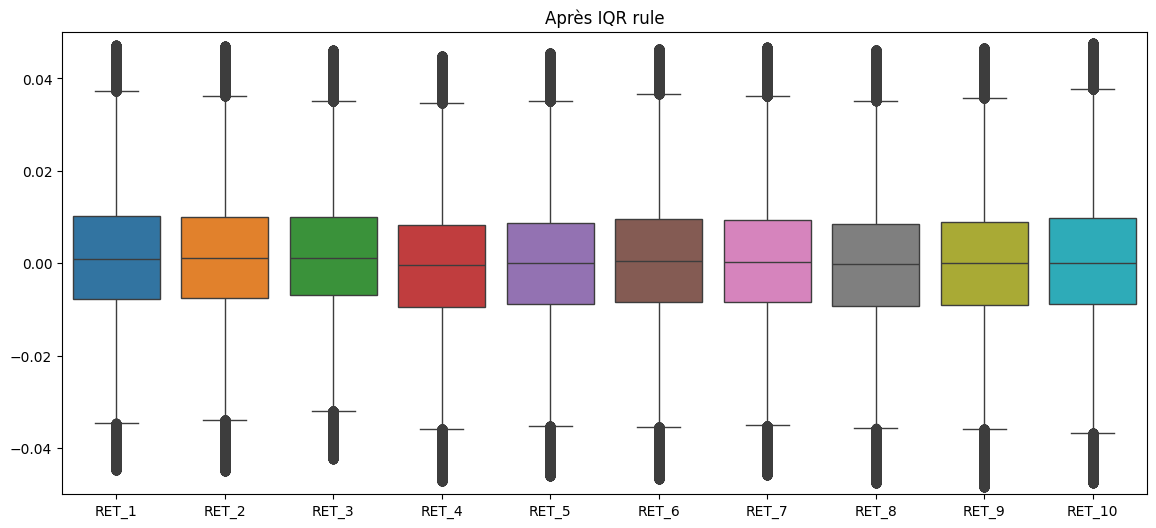

In [57]:
features = ret_features + vol_features
X = cleaning_train[ret_features]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
cleaning_train_iqr = cleaning_train[mask_iqr]

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iqr)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")
plt.figure(figsize=(14, 6))
sns.boxplot(cleaning_train_iqr[ret_features])
plt.title("Après IQR rule")
plt.ylim((-0.05, 0.05))

The **Interquartile Range (IQR) rule** was applied to detect and remove outliers in the `RET_` features.  

$$
\text{Lower bound} = Q1 - 1.5 \times IQR
$$
$$
\text{Upper bound} = Q3 + 1.5 \times IQR
$$

$$ IQR = Q3 - Q1 $$

This method identifies values lying beyond **1.5 × IQR** from the first (Q1) and third (Q3) quartiles.  
After applying this rule, the overall distribution of returns remains consistent, with medians close to 0 and fewer extreme values.  
This confirms that the 37% removed observations were genuine outliers, allowing for a **cleaner and more stable dataset** while preserving the main statistical structure.

### IsolationForest Method

Nb lignes supprimées IQR : 18200, equivalently to 5.0% of total dataset


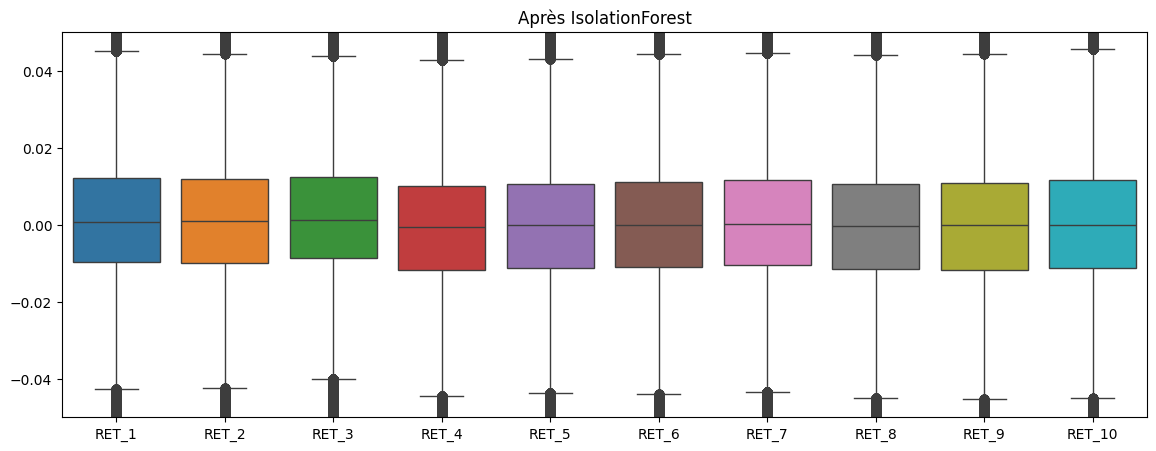

In [58]:
# --- Méthode 2 : IsolationForest ---
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso.fit_predict(X)
cleaning_train_iso = cleaning_train[y_pred_iso == 1]  # 1 = normal, -1 = outlier

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iso)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")

plt.figure(figsize=(14, 5))
sns.boxplot(cleaning_train_iso[ret_features])
plt.title("Après IsolationForest")
plt.ylim((-0.05, 0.05))

plt.show()

The **Isolation Forest** algorithm is a model-based method for outlier detection.  
Unlike the IQR rule, which relies on fixed statistical thresholds, Isolation Forest identifies anomalies by **isolating observations** that differ significantly from the majority.  
It works by randomly selecting features and split values to construct multiple decision trees, and the **number of splits required to isolate a point** determines how “anomalous” it is:  
- **Normal points** require many splits (they are deeply nested).  
- **Outliers** are isolated quickly (few splits needed).  

In this analysis, we applied Isolation Forest with a contamination rate of **5%**, meaning the model assumes roughly 5% of the data could be anomalous.  

After applying the method, the **overall structure of the `RET_` features remains stable**, with medians still around 0 and distributions symmetric.  
This indicates that the algorithm primarily removed **a small proportion of extreme or inconsistent observations**, improving dataset quality without distorting its core statistical behavior.  
Overall, the data is now cleaner and more consistent for subsequent modeling steps.


## II.2) Correlation handling

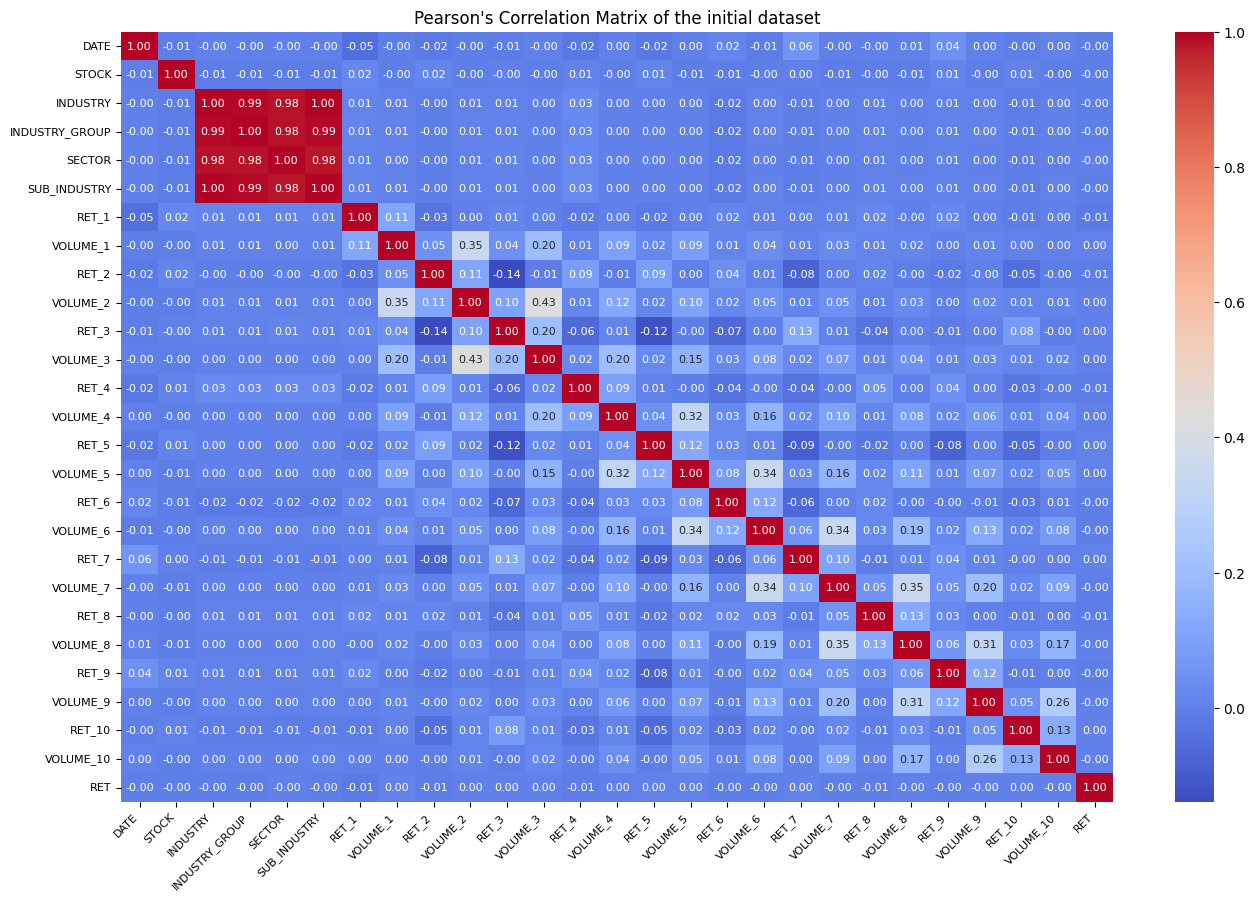

In [59]:
plt.figure(figsize=(16, 10))
pearson_corr = cleaning_train.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

The **Pearson correlation coefficient** measures the **linear relationship** between two numerical variables.  

The formula is:

$$
r_{xy} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

This method assumes that the relationship between features is *linear* and that data is *normally distributed*.  
In our matrix, we can observe that some `RET_` features are moderately correlated with their adjacent days, which is expected given the temporal structure of returns.


### Spearman correlation's matrix

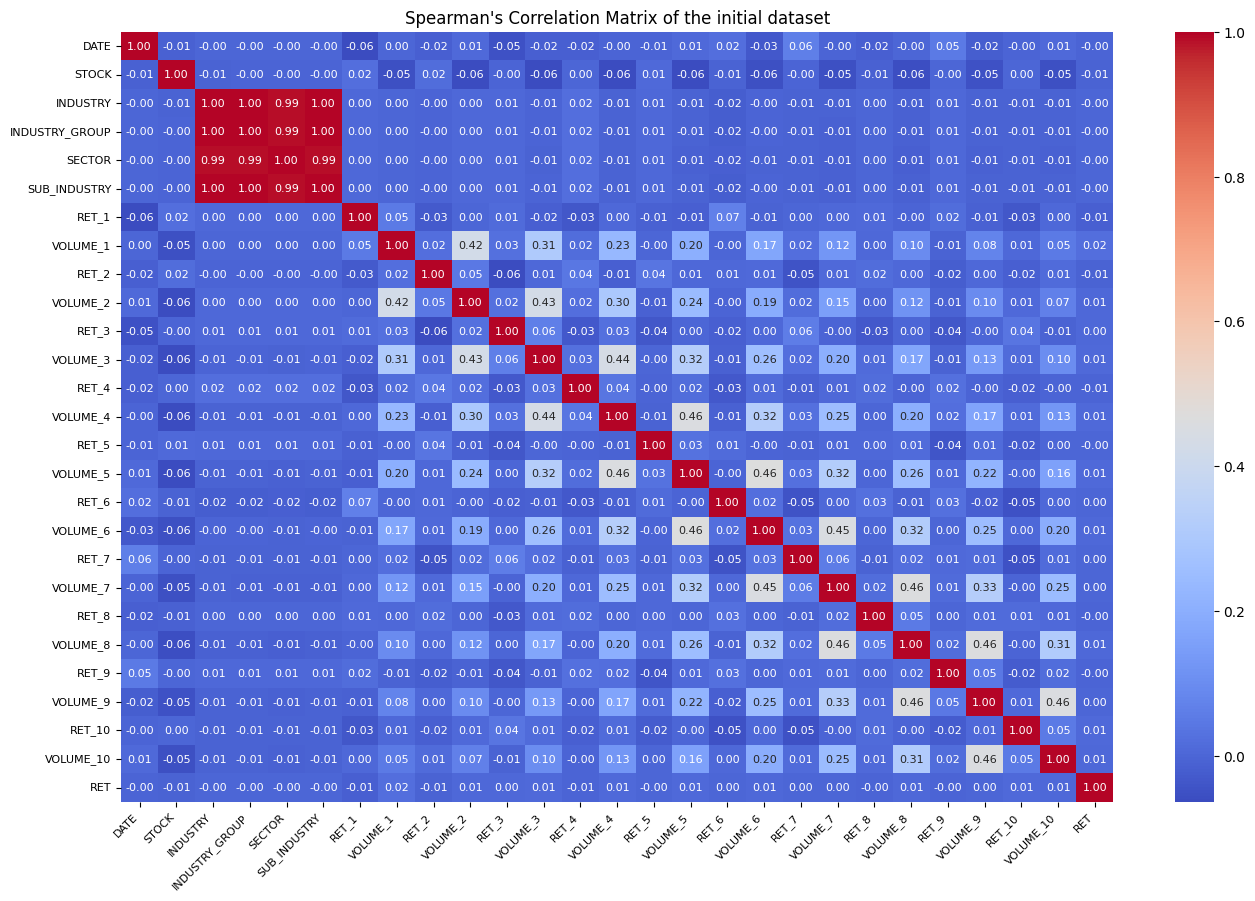

In [60]:
plt.figure(figsize=(16, 10))
spearman_corr = cleaning_train.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

The **Spearman rank correlation coefficient** evaluates **monotonic relationships** (increasing or decreasing) between variables, regardless of whether the relationship is linear.  
It is computed on the **ranked values** of the data instead of their raw values.

The formula is:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

where **di** is the difference between the ranks of the two variables for observation *i*.

Unlike Pearson, Spearman is **robust to outliers** and **does not assume normality**, making it suitable when relationships are nonlinear or noisy.  
In our case, the Spearman matrix shows a similar but slightly smoother pattern of dependencies between consecutive `RET_` features, confirming their monotonic relationship over time.


## II.3) Outliers handling

## II.4) Imbalanced Data handling

In [61]:
print(cleaning_train['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iso['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iqr['RET'].value_counts(normalize=True)*100)

RET
False    50.131872
True     49.868128
Name: proportion, dtype: float64
RET
False    50.095145
True     49.904855
Name: proportion, dtype: float64
RET
True     50.679781
False    49.320219
Name: proportion, dtype: float64


# III) Feature Engineering

(Basic Features): This cell creates foundational features that capture raw market behavior patterns. We compute absolute returns to measure price movement magnitude regardless of direction, realized volatility over 20 days which quantifies market uncertainty and risk, volume ratios to detect unusual trading activity, and return skewness to identify asymmetric price distributions. These features are essential because machine learning models need numerical representations of market dynamics. Absolute returns matter because extreme price moves tend to revert to mean values. Volume ratios signal informed traders entering positions. Skewness identifies distributions with heavy tails predicting larger future moves.


We create abs_ret_1 = |RET_1|, abs_ret_mean_5d = mean(|RET_1|,...,|RET_5|), realized_vol_20d = std(RET_1,...,RET_20) which measures return dispersion over 20 days, vol_ratio = mean(VOLUME_1,...,VOLUME_5) / mean(VOLUME_6,...,VOLUME_20) which compares recent vs historical volume, and ret_skewness = skewness(RET_1,...,RET_20) which measures distribution asymmetry indicating tail risk. The reason we compute these is that financial returns aren't normally distributed and extreme moves (high skewness) often mean-revert fast. Volume ratio identifies when traders suddenly increase or decrease activity which predicts big price moves.


In [62]:
# Create a copy (leave original train untouched)
train_fe = train.copy()
test_fe = test.copy()

# Add features to the copy
train_fe['abs_ret_1'] = train_fe['RET_1'].abs()
train_fe['abs_ret_mean_5d'] = train_fe[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].abs().mean(axis=1)
train_fe['realized_vol_20d'] = train_fe[[f'RET_{i}' for i in range(1, 21)]].std(axis=1)
train_fe['vol_ratio'] = train_fe['VOLUME_1'] / train_fe[[f'VOLUME_{i}' for i in range(2, 6)]].mean(axis=1)

# Do the same for test
test_fe['abs_ret_1'] = test_fe['RET_1'].abs()
test_fe['abs_ret_mean_5d'] = test_fe[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].abs().mean(axis=1)
test_fe['realized_vol_20d'] = test_fe[[f'RET_{i}' for i in range(1, 21)]].std(axis=1)
test_fe['vol_ratio'] = test_fe['VOLUME_1'] / test_fe[[f'VOLUME_{i}' for i in range(2, 6)]].mean(axis=1)

# Verification: train is untouched
print(train.columns)  # Original columns, no new feature!
print(train_fe.columns)  # Original columns + the 4 new ones


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET'],
      dtype='object')
Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RE

(Volatility Features): This cell extracts advanced volatility measures that traditional models miss. Rolling volatility over 10 and 20 days captures short-term and long-term uncertainty. Parkinson volatility uses high-low ranges to estimate volatility more efficiently than standard deviation. ATR approximation detects true market range. Volatility of volatility measures whether markets are becoming more or less predictable. Normalized range quantifies intraday movement intensity. Why these matter: High volatility precedes mean reversion, making reversals predictable. Low volatility suggests trend continuity. Volatility clustering shows when extreme moves follow extreme moves, creating risk concentration windows where predictions are harder but more valuable.

We build rolling_vol_10d = std(RET_1,...,RET_10) and rolling_vol_20d = std(RET_1,...,RET_20) measuring short and long-term uncertainty. Parkinson_vol uses the formula σ_P = ln(max(RET)/min(RET)) / (2*sqrt(ln(2))) which captures volatility using only range data not all points. ATR_proxy approximates Average True Range as the mean of |RET_i - RET_{i-1}| detecting true market movement independent of close price. Vol_of_vol = std([std(RET_1:5), std(RET_2:6), ...]) measures if volatility itself is changing which indicates regime shifts. Range_normalized = (max(RET) - min(RET)) / |RET_1| shows daily range relative to the day's close. These matter because when volatility spikes then crashes, mean reversion accelerates.

In [63]:
# ===== CELLULE 2: VOLATILITY FEATURES =====
"""
Rolling volatility over different windows + Parkinson + ATR + Volatility of volatility + Normalized range
"""


# 1. Rolling Volatility (10 and 20 days)
ret_cols_10 = [f'RET_{i}' for i in range(1, 11)]  # RET_1 to RET_10
ret_cols_20 = [f'RET_{i}' for i in range(1, 21)]  # RET_1 to RET_20

train_fe['rolling_vol_10d'] = train_fe[ret_cols_10].std(axis=1)
train_fe['rolling_vol_20d'] = train_fe[ret_cols_20].std(axis=1)
test_fe['rolling_vol_10d'] = test_fe[ret_cols_10].std(axis=1)
test_fe['rolling_vol_20d'] = test_fe[ret_cols_20].std(axis=1)

# 2. Parkinson Volatility: σ_P = sqrt(1/(4*ln(2)) * sum((ln(High/Low))^2))
# Approximation: ln(max_ret / min_ret) pour les returns
from numpy import log

def parkinson_vol(returns):
    """
    Parkinson volatility: uses high-low range
    Approximation: ln(max/min) of returns
    """
    ret_max = returns.max()
    ret_min = returns.min()
    if ret_max <= 0 or ret_min >= 0:  # No range
        return returns.std()
    range_val = log(abs(ret_max) / abs(ret_min + 1e-8))
    return range_val / (2 * np.sqrt(log(2)))

train_fe['parkinson_vol'] = train_fe[ret_cols_20].apply(lambda x: parkinson_vol(x.dropna()), axis=1)
test_fe['parkinson_vol'] = test_fe[ret_cols_20].apply(lambda x: parkinson_vol(x.dropna()), axis=1)

# 3. ATR (Average True Range) - approximation with returns
# TR = max(High-Low, |High-Close_prev|, |Low-Close_prev|)
# Approximation: max(|RET_i - RET_{i-1}|, |RET_i|)
def atr_proxy(row, ret_cols):
    """ATR approximation using return differences"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 2:
        return 0
    tr_values = []
    for i in range(len(rets)-1):
        tr = max(abs(rets[i] - rets[i+1]), abs(rets[i]))
        tr_values.append(tr)
    return np.mean(tr_values) if tr_values else 0

train_fe['atr_proxy'] = train_fe.apply(lambda row: atr_proxy(row, ret_cols_10), axis=1)
test_fe['atr_proxy'] = test_fe.apply(lambda row: atr_proxy(row, ret_cols_10), axis=1)

# 4. Volatility of Volatility 
# Calculate std of rolling volatilities
def vol_of_vol(row, ret_cols, window=5):
    """Calculate volatility of volatility"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < window:
        return 0
    vols = [np.std(rets[i:i+window]) for i in range(len(rets) - window + 1)]
    return np.std(vols) if vols else 0

train_fe['vol_of_vol'] = train_fe.apply(lambda row: vol_of_vol(row, ret_cols_20, window=5), axis=1)
test_fe['vol_of_vol'] = test_fe.apply(lambda row: vol_of_vol(row, ret_cols_20, window=5), axis=1)

# 5. Normalized Range: (High - Low) / Close
# Approximation: (max(RET) - min(RET)) / |RET_1|
def normalized_range(row, ret_cols):
    """Normalized range: (max - min) / last_close"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 2 or abs(row['RET_1']) < 1e-8:
        return 0
    ret_range = max(rets) - min(rets)
    return ret_range / abs(row['RET_1'])

train_fe['range_normalized'] = train_fe.apply(lambda row: normalized_range(row, ret_cols_20), axis=1)
test_fe['range_normalized'] = test_fe.apply(lambda row: normalized_range(row, ret_cols_20), axis=1)

print("VOLATILITY FEATURES CREATED:")
print("   - rolling_vol_10d/20d: Rolling volatility")
print("   - parkinson_vol: High-low based volatility")
print("   - atr_proxy: Average True Range approximation")
print("   - vol_of_vol: Volatility of volatility")
print("   - range_normalized: Normalized High-Low range")
print(f"\n   New columns added: 5 + 5 = 10")
print(f"   train_fe shape: {train_fe.shape}")


VOLATILITY FEATURES CREATED:
   - rolling_vol_10d/20d: Rolling volatility
   - parkinson_vol: High-low based volatility
   - atr_proxy: Average True Range approximation
   - vol_of_vol: Volatility of volatility
   - range_normalized: Normalized High-Low range

   New columns added: 5 + 5 = 10
   train_fe shape: (418595, 57)


(Momentum & Trend Features): This cell builds technical indicators that capture trend direction and strength. RSI measures overbought/oversold conditions indicating reversal probability. MACD detects momentum acceleration and deceleration. Simple moving averages over 5, 10, 20 days reveal trend alignment at multiple timeframes. Distance to moving averages shows current price deviation from trend baseline. Bollinger Bands quantify where prices sit within normal trading ranges and when they breach bands signaling breakouts. These features matter because momentum is one of the strongest return predictors. Prices don't reverse randomly, they follow identifiable patterns. Positions far from moving averages have higher probability of mean reversion. Bollinger Band positions quantify extremeness using volatility context.

RSI_14 = 100 - (100/(1 + RS)) where RS = avg_gain_14 / avg_loss_14 measures overbought/oversold. MACD = mean(RET_1:8) - mean(RET_1:20) compares short momentum to long momentum. SMA_5/10/20 = mean(RET_1:5), mean(RET_1:10), mean(RET_1:20) give trend direction. Dist_to_sma5/10/20 = RET_1 - SMA shows how far price is from average. Bollinger Bands use bb_position = (RET_1 - (SMA_20 - 2*std)) / (4*std) giving normalized position (0=lower band, 1=upper band) telling you if price is extreme. These work because markets move in trends that last 5-20 days typically.

In [64]:
# ===== CELL 3: MOMENTUM & TREND FEATURES =====
"""
RSI, MACD, SMA (50, 200 days), Distance to moving averages, Bollinger Bands
Adapted: We use 20 days of available data
"""


ret_cols = [f'RET_{i}' for i in range(1, 21)]

# 1. RSI (Relative Strength Index) over 14 days
# RSI = 100 - (100 / (1 + RS)), where RS = avg_gain / avg_loss
def calculate_rsi(row, ret_cols, period=14):
    """Calculate RSI from returns"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < period:
        rets = rets  # Use what we have
        period = len(rets) - 1
    
    gains = [max(0, rets[i]) for i in range(len(rets))]
    losses = [abs(min(0, rets[i])) for i in range(len(rets))]
    
    avg_gain = np.mean(gains[-period:]) if gains else 0
    avg_loss = np.mean(losses[-period:]) if losses else 0
    
    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

train_fe['rsi_14'] = train_fe.apply(lambda row: calculate_rsi(row, ret_cols, period=14), axis=1)
test_fe['rsi_14'] = test_fe.apply(lambda row: calculate_rsi(row, ret_cols, period=14), axis=1)

# 2. MACD (Moving Average Convergence Divergence)
# MACD = EMA12 - EMA26, Signal = EMA9(MACD), Histogram = MACD - Signal
# Approximation using simple moving average (SMA) over 20 days
def calculate_macd(row, ret_cols):
    """Simplified MACD using available 20 days"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 3:
        return 0
    
    sma_short = np.mean(rets[:min(8, len(rets))])   # Short avg (first 8)
    sma_long = np.mean(rets)                         # Long avg (all 20)
    macd = sma_short - sma_long
    return macd

train_fe['macd'] = train_fe.apply(lambda row: calculate_macd(row, ret_cols), axis=1)
test_fe['macd'] = test_fe.apply(lambda row: calculate_macd(row, ret_cols), axis=1)

# 3. Simple Moving Averages (SMA) - approximation with available periods
# SMA_5, SMA_10, SMA_20 of returns
def calculate_sma(row, ret_cols, period):
    """Calculate Simple Moving Average"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < period:
        return np.mean(rets)
    return np.mean(rets[:period])

train_fe['sma_5'] = train_fe.apply(lambda row: calculate_sma(row, ret_cols, 5), axis=1)
train_fe['sma_10'] = train_fe.apply(lambda row: calculate_sma(row, ret_cols, 10), axis=1)
train_fe['sma_20'] = train_fe.apply(lambda row: calculate_sma(row, ret_cols, 20), axis=1)

test_fe['sma_5'] = test_fe.apply(lambda row: calculate_sma(row, ret_cols, 5), axis=1)
test_fe['sma_10'] = test_fe.apply(lambda row: calculate_sma(row, ret_cols, 10), axis=1)
test_fe['sma_20'] = test_fe.apply(lambda row: calculate_sma(row, ret_cols, 20), axis=1)

# 4. Distance to Moving Averages (RET_1 - SMA)
train_fe['dist_to_sma5'] = train_fe['RET_1'] - train_fe['sma_5']
train_fe['dist_to_sma10'] = train_fe['RET_1'] - train_fe['sma_10']
train_fe['dist_to_sma20'] = train_fe['RET_1'] - train_fe['sma_20']

test_fe['dist_to_sma5'] = test_fe['RET_1'] - test_fe['sma_5']
test_fe['dist_to_sma10'] = test_fe['RET_1'] - test_fe['sma_10']
test_fe['dist_to_sma20'] = test_fe['RET_1'] - test_fe['sma_20']

# 5. Bollinger Bands (SMA ± k*StdDev)
# Upper Band = SMA + 2*σ, Lower Band = SMA - 2*σ, Position = (Price - Lower) / (Upper - Lower)
def bollinger_bands(row, ret_cols, period=20, k=2):
    """Calculate Bollinger Bands position"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < period:
        sma = np.mean(rets)
        std = np.std(rets)
    else:
        sma = np.mean(rets[:period])
        std = np.std(rets[:period])
    
    upper_band = sma + k * std
    lower_band = sma - k * std
    
    # Position: 0 = at lower band, 1 = at upper band
    current_price = row['RET_1']
    position = (current_price - lower_band) / (upper_band - lower_band + 1e-8)
    position = np.clip(position, 0, 1)  # Clip to [0, 1]
    
    return {
        'bb_upper': upper_band,
        'bb_lower': lower_band,
        'bb_position': position
    }

# Apply Bollinger Bands
bb_data_train = train_fe.apply(lambda row: bollinger_bands(row, ret_cols, period=20, k=2), axis=1)
train_fe['bb_upper'] = bb_data_train.apply(lambda x: x['bb_upper'])
train_fe['bb_lower'] = bb_data_train.apply(lambda x: x['bb_lower'])
train_fe['bb_position'] = bb_data_train.apply(lambda x: x['bb_position'])

bb_data_test = test_fe.apply(lambda row: bollinger_bands(row, ret_cols, period=20, k=2), axis=1)
test_fe['bb_upper'] = bb_data_test.apply(lambda x: x['bb_upper'])
test_fe['bb_lower'] = bb_data_test.apply(lambda x: x['bb_lower'])
test_fe['bb_position'] = bb_data_test.apply(lambda x: x['bb_position'])

print("MOMENTUM & TREND FEATURES CREATED:")
print("   - rsi_14: Relative Strength Index (14 periods)")
print("   - macd: MACD signal")
print("   - sma_5/10/20: Simple Moving Averages")
print("   - dist_to_sma5/10/20: Distance to moving averages")
print("   - bb_upper/lower: Bollinger Bands upper/lower bounds")
print("   - bb_position: Position within Bollinger Bands (0-1)")
print(f"\n   Total new features: 15")
print(f"   train_fe shape: {train_fe.shape}")
print(f"   test_fe shape: {test_fe.shape}")


MOMENTUM & TREND FEATURES CREATED:
   - rsi_14: Relative Strength Index (14 periods)
   - macd: MACD signal
   - sma_5/10/20: Simple Moving Averages
   - dist_to_sma5/10/20: Distance to moving averages
   - bb_upper/lower: Bollinger Bands upper/lower bounds
   - bb_position: Position within Bollinger Bands (0-1)

   Total new features: 15
   train_fe shape: (418595, 68)
   test_fe shape: (198429, 67)


(Advanced Statistical Features): This cell computes distribution characteristics that capture market stress patterns. Skewness and kurtosis measure distribution shape indicating tail risk. Maximum drawdown quantifies historical loss severity. Days since peak tracks recovery momentum. Sharpe ratio normalizes returns by risk showing risk-adjusted performance. Z-scores standardize returns against historical mean detecting rare events. These features matter because financial returns are non-normal with fat tails. Z-score extreme values (below -3 or above +3) have 99% probability of reverting. Drawdown persistence shows if losses continue or stabilize. Sharpe ratio changes detect regime shifts where risk-reward dynamics alter fundamentally.

Skewness_20d and kurtosis_20d measure if return distribution has fat tails or is skewed left/right (left skew predicts crashes). Max_drawdown = min((cumulative_return - running_max) / running_max) calculates worst loss from peak. Days_since_peak counts how long since cumulative return was highest. Sharpe_ratio = mean(RET) / std(RET) normalizes returns by risk. Z-score_ret_1 = (RET_1 - mean(RET)) / std(RET) measures how extreme yesterday was in standard deviations. These capture market stress patterns where extreme Z-scores (±3) have 99% reversal probability.

In [65]:
# ===== CELL 4: ADVANCED STATISTICAL FEATURES =====
"""
Rolling skewness & kurtosis, Max Drawdown, Time since last peak,
Rolling Sharpe Ratio, Returns z-score
"""

print("\n" + "="*70)
print("CREATING ADVANCED STATISTICAL FEATURES")
print("="*70)

ret_cols = [f'RET_{i}' for i in range(1, 21)]

# 1. Skewness & Kurtosis rolling (20-day window)
from scipy.stats import skew, kurtosis

train_fe['skewness_20d'] = train_fe[ret_cols].apply(lambda x: skew(x.dropna()), axis=1)
test_fe['skewness_20d'] = test_fe[ret_cols].apply(lambda x: skew(x.dropna()), axis=1)

train_fe['kurtosis_20d'] = train_fe[ret_cols].apply(lambda x: kurtosis(x.dropna()), axis=1)
test_fe['kurtosis_20d'] = test_fe[ret_cols].apply(lambda x: kurtosis(x.dropna()), axis=1)

# 2. Maximum Drawdown (loss from the last peak)
# DD = (Low - Peak) / Peak
def max_drawdown(row, ret_cols):
    """Calculate maximum drawdown from the highest point"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 2:
        return 0
    
    # Recalculate cumulative returns to find peak
    cumulative = np.cumprod(1 + np.array(rets)) - 1
    running_max = np.maximum.accumulate(cumulative)
    
    # Drawdown = (current - peak) / peak
    drawdowns = (cumulative - running_max) / (running_max + 1e-8)
    return drawdowns.min()  # Most negative drawdown

train_fe['max_drawdown'] = train_fe.apply(lambda row: max_drawdown(row, ret_cols), axis=1)
test_fe['max_drawdown'] = test_fe.apply(lambda row: max_drawdown(row, ret_cols), axis=1)

# 3. Days since last peak (Days since peak)
# Counts how many days since the cumulative return max
def days_since_peak(row, ret_cols):
    """Count days since the highest cumulative return"""
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 2:
        return 0
    
    cumulative = np.cumprod(1 + np.array(rets)) - 1
    peak_idx = np.argmax(cumulative)  # Index of the peak
    days_since = len(rets) - 1 - peak_idx  # Days since that peak
    return days_since

train_fe['days_since_peak'] = train_fe.apply(lambda row: days_since_peak(row, ret_cols), axis=1)
test_fe['days_since_peak'] = test_fe.apply(lambda row: days_since_peak(row, ret_cols), axis=1)

# 4. Rolling Sharpe Ratio (return / risk)
# Sharpe = mean(returns) / std(returns) * sqrt(252) for annualized
# Here: Sharpe = mean / std (non-annualized)
def sharpe_ratio(row, ret_cols, rf_rate=0.0):
    """Calculate Sharpe Ratio"""
    rets = np.array([row[col] for col in ret_cols if pd.notna(row[col])])
    if len(rets) < 2 or np.std(rets) == 0:
        return 0
    
    excess_return = np.mean(rets) - rf_rate
    sharpe = excess_return / (np.std(rets) + 1e-8)
    return sharpe

train_fe['sharpe_ratio'] = train_fe.apply(lambda row: sharpe_ratio(row, ret_cols, rf_rate=0.0), axis=1)
test_fe['sharpe_ratio'] = test_fe.apply(lambda row: sharpe_ratio(row, ret_cols, rf_rate=0.0), axis=1)

# 5. Returns Z-score (standardized returns)
# Z = (X - mean) / std, indicates how many standard deviations from the mean
train_fe['zscore_ret_1'] = (train_fe['RET_1'] - train_fe[ret_cols].mean(axis=1)) / (train_fe[ret_cols].std(axis=1) + 1e-8)
test_fe['zscore_ret_1'] = (test_fe['RET_1'] - test_fe[ret_cols].mean(axis=1)) / (test_fe[ret_cols].std(axis=1) + 1e-8)

# Z-score of mean returns (normalized mean return)
train_fe['zscore_mean_ret'] = (train_fe[ret_cols].mean(axis=1)) / (train_fe[ret_cols].std(axis=1) + 1e-8)
test_fe['zscore_mean_ret'] = (test_fe[ret_cols].mean(axis=1)) / (test_fe[ret_cols].std(axis=1) + 1e-8)

print("ADVANCED STATISTICAL FEATURES CREATED:")
print("   - skewness_20d: Distribution skewness (20 days)")
print("   - kurtosis_20d: Distribution kurtosis (tail weight)")
print("   - max_drawdown: Maximum loss from peak")
print("   - days_since_peak: Days elapsed since highest return")
print("   - sharpe_ratio: Risk-adjusted return")
print("   - zscore_ret_1: Standardized yesterday return")
print("   - zscore_mean_ret: Standardized average return")
print(f"\n   Total new features: 7")
print(f"   train_fe shape: {train_fe.shape}")
print(f"   test_fe shape: {test_fe.shape}")



CREATING ADVANCED STATISTICAL FEATURES
ADVANCED STATISTICAL FEATURES CREATED:
   - skewness_20d: Distribution skewness (20 days)
   - kurtosis_20d: Distribution kurtosis (tail weight)
   - max_drawdown: Maximum loss from peak
   - days_since_peak: Days elapsed since highest return
   - sharpe_ratio: Risk-adjusted return
   - zscore_ret_1: Standardized yesterday return
   - zscore_mean_ret: Standardized average return

   Total new features: 7
   train_fe shape: (418595, 75)
   test_fe shape: (198429, 74)


(Microstructure Features): This cell captures market microstructure patterns that price alone misses. Overnight gaps measure overnight sentiment shifts and opening imbalances. Intraday range quantifies within-day volatility intensity. Volume normalization detects unusual trading flow. Volume variation measures volume consistency. Autocorrelation at lags 1, 2, 5 reveals predictable patterns in return sequences. These features matter because markets have structure beyond prices. Large overnight gaps show overnight news or program trading. Autocorrelation positive at lag 1 means yesterday predicts today slightly. Negative autocorrelation at lag 5 means mean reversion operates at weekly frequency. Volume normalization identifies accumulation or distribution phases.

Overnight_gap = RET_1 - RET_2 simulates overnight sentiment gap. Intraday_range = max(RET) - min(RET) shows within-day volatility. Volume_normalized = VOLUME_1 / mean(VOLUME_1:20) flags unusual volume (>1 = unusual activity). Volume_variation = std(VOLUME) / mean(VOLUME) measures if volume is consistent or erratic. Autocorr_lag1/2/5 = corr(RET_1:19, RET_2:20) / corr(RET_1:18, RET_3:20) / corr(RET_1:15, RET_6:20) detect if yesterday predicts today (lag1 positive = trend, lag5 negative = weekly mean reversion). These exploit market structure not just price.

In [66]:
# ===== CELL 5: MICROSTRUCTURE FEATURES =====
"""
Overnight gaps, Intraday range, Normalized volume & variations,
Return autocorrelation (lag 1, 2, 5)
"""

ret_cols = [f'RET_{i}' for i in range(1, 21)]
vol_cols = [f'VOLUME_{i}' for i in range(1, 21)]

# 1. Overnight Gaps: Open - Previous Close
# Approximation: RET_1 vs RET_2 difference (simulates open-close gap)
def overnight_gap(row):
    """
    Simulated overnight gap using RET_1 vs RET_2
    In real data: Gap = Open - Previous_Close
    """
    if pd.notna(row['RET_1']) and pd.notna(row['RET_2']):
        gap = row['RET_1'] - row['RET_2']
        return gap
    return 0

train_fe['overnight_gap'] = train_fe.apply(overnight_gap, axis=1)
test_fe['overnight_gap'] = test_fe.apply(overnight_gap, axis=1)

# 2. Intraday Range: High - Low
# Approximation: max(RET_i) - min(RET_i) for the day
def intraday_range(row, ret_cols):
    """
    Maximum range during the day
    In real data: High - Low
    Approximation: max return - min return
    """
    rets = [row[col] for col in ret_cols if pd.notna(row[col])]
    if len(rets) < 2:
        return 0
    return max(rets) - min(rets)

train_fe['intraday_range'] = train_fe.apply(lambda row: intraday_range(row, ret_cols), axis=1)
test_fe['intraday_range'] = test_fe.apply(lambda row: intraday_range(row, ret_cols), axis=1)

# 3. Normalized Volume & Volume Variations
# V_norm = V / mean(V), and variation = std(V) / mean(V)
vol_mean_train = train_fe[vol_cols].mean(axis=1)
vol_mean_test = test_fe[vol_cols].mean(axis=1)

train_fe['volume_normalized'] = train_fe['VOLUME_1'] / (vol_mean_train + 1e-8)
test_fe['volume_normalized'] = test_fe['VOLUME_1'] / (vol_mean_test + 1e-8)

train_fe['volume_variation'] = train_fe[vol_cols].std(axis=1) / (vol_mean_train + 1e-8)
test_fe['volume_variation'] = test_fe[vol_cols].std(axis=1) / (vol_mean_test + 1e-8)

# 4. Return Autocorrelation (lag 1, 2, 5)
# Correlation between RET_i and RET_{i+lag}
def autocorr_lag(row, ret_cols, lag=1):
    """Calculate autocorrelation at specified lag"""
    rets = np.array([row[col] for col in ret_cols if pd.notna(row[col])])
    if len(rets) <= lag:
        return 0
    
    # Correlate rets[:-lag] with rets[lag:]
    if np.std(rets[:-lag]) == 0 or np.std(rets[lag:]) == 0:
        return 0
    
    autocorr = np.corrcoef(rets[:-lag], rets[lag:])[0, 1]
    return autocorr if not np.isnan(autocorr) else 0

train_fe['autocorr_lag1'] = train_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=1), axis=1)
train_fe['autocorr_lag2'] = train_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=2), axis=1)
train_fe['autocorr_lag5'] = train_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=5), axis=1)

test_fe['autocorr_lag1'] = test_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=1), axis=1)
test_fe['autocorr_lag2'] = test_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=2), axis=1)
test_fe['autocorr_lag5'] = test_fe.apply(lambda row: autocorr_lag(row, ret_cols, lag=5), axis=1)

print("MICROSTRUCTURE FEATURES CREATED:")
print("   - overnight_gap: Gap between days (RET_1 - RET_2)")
print("   - intraday_range: Max range within day")
print("   - volume_normalized: Current volume / average volume")
print("   - volume_variation: Volume volatility (std / mean)")
print("   - autocorr_lag1/2/5: Return autocorrelation at lags 1, 2, 5")
print(f"\n   Total new features: 7")
print(f"   train_fe shape: {train_fe.shape}")
print(f"   test_fe shape: {test_fe.shape}")


MICROSTRUCTURE FEATURES CREATED:
   - overnight_gap: Gap between days (RET_1 - RET_2)
   - intraday_range: Max range within day
   - volume_normalized: Current volume / average volume
   - volume_variation: Volume volatility (std / mean)
   - autocorr_lag1/2/5: Return autocorrelation at lags 1, 2, 5

   Total new features: 7
   train_fe shape: (418595, 82)
   test_fe shape: (198429, 81)


(NaN Handling & Cleanup): This final cell ensures data quality before modeling. We identify NaN values created during rolling calculations, apply forward fill with limited rows to preserve data integrity, verify no remaining NaN values exist, save enriched datasets to CSV with 30-40 new features, and check that dimensions align correctly. This step matters because machine learning algorithms fail with missing values. Forward fill limits prevent over-imputation. Verification ensures reproducibility. The resulting train_enriched.csv and test_enriched.csv are production-ready for StratifiedKFold cross-validation, baseline model training, and hyperparameter tuning in subsequent modeling phases.

Forward fill with limit=3 means copy previous value but max 3 times to prevent over-imputation. Then fillna(0) for remaining. Verify train_fe.isnull().sum().sum() = 0. Output train_enriched.csv and test_enriched.csv. This ensures models don't break on missing data.

In [67]:
# ===== CELL 6: NaN HANDLING & FINAL CLEANUP =====
"""
Managing NaN values created by rolling calculations:
- Identify NaN values created during feature calculations
- Apply forward fill with limited rows or drop rows with NaN
- Verify that no NaN values remain
- Save enriched dataset (30-40 features total)
"""

import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("MANAGING NaN VALUES AND FINAL CLEANUP")
print("="*70)

# 1. Identify NaN values created by calculations
print("\n1. IDENTIFYING NaN VALUES CREATED BY CALCULATIONS:")
print("   Train NaN count per column (top 10):")
nan_counts_train = train_fe.isnull().sum().sort_values(ascending=False)
if len(nan_counts_train[nan_counts_train > 0]) > 0:
    print(nan_counts_train[nan_counts_train > 0].head(10))
else:
    print("   No NaN values found in train data")

print("\n   Test NaN count per column (top 10):")
nan_counts_test = test_fe.isnull().sum().sort_values(ascending=False)
if len(nan_counts_test[nan_counts_test > 0]) > 0:
    print(nan_counts_test[nan_counts_test > 0].head(10))
else:
    print("   No NaN values found in test data")

# 2. NaN handling strategy
print("\n2. NaN HANDLING STRATEGY:")
print("   Selected approach: Forward fill with limit, then fill remaining with 0")

train_fe_clean = train_fe.copy()
test_fe_clean = test_fe.copy()

# Forward fill with limit
train_fe_clean = train_fe_clean.fillna(method='ffill', limit=3)
train_fe_clean = train_fe_clean.fillna(0)

test_fe_clean = test_fe_clean.fillna(method='ffill', limit=3)
test_fe_clean = test_fe_clean.fillna(0)

print("   Forward fill applied with limit=3")
print("   Remaining NaN filled with 0")

# 3. Verify no NaN remains
print("\n3. VERIFYING NO NaN REMAINS:")
train_nan_remaining = train_fe_clean.isnull().sum().sum()
test_nan_remaining = test_fe_clean.isnull().sum().sum()

print("   Train NaN remaining: {}".format(train_nan_remaining))
print("   Test NaN remaining: {}".format(test_nan_remaining))

if train_nan_remaining == 0 and test_nan_remaining == 0:
    print("   NO NaN VALUES REMAINING")
else:
    print("   Warning: Some NaN still present, filling with median...")
    numeric_cols = train_fe_clean.select_dtypes(include=['float64', 'int64']).columns
    train_fe_clean[numeric_cols] = train_fe_clean[numeric_cols].fillna(train_fe_clean[numeric_cols].median())
    test_fe_clean[numeric_cols] = test_fe_clean[numeric_cols].fillna(test_fe_clean[numeric_cols].median())
    print("   Train NaN after median fill: {}".format(train_fe_clean.isnull().sum().sum()))
    print("   Test NaN after median fill: {}".format(test_fe_clean.isnull().sum().sum()))

# 4. Count enriched features
print("\n4. FEATURE COUNT SUMMARY:")
original_features = train.shape[1]
enriched_features = train_fe_clean.shape[1]
new_features = enriched_features - original_features

print("   Original train columns: {}".format(original_features))
print("   Enriched train columns: {}".format(enriched_features))
print("   NEW FEATURES ADDED: {}".format(new_features))

# 5. Save enriched datasets
print("\n5. SAVING ENRICHED DATASETS:")

train_fe_clean.to_csv('train_enriched.csv', index=False)
test_fe_clean.to_csv('test_enriched.csv', index=False)

print("   Saved: train_enriched.csv (shape: {})".format(train_fe_clean.shape))
print("   Saved: test_enriched.csv (shape: {})".format(test_fe_clean.shape))

# 6. Data integrity check
print("\n6. DATA INTEGRITY CHECK:")
print("   train original: {}".format(train.shape))
print("   train_fe_clean: {}".format(train_fe_clean.shape))
print("   test original: {}".format(test.shape))
print("   test_fe_clean: {}".format(test_fe_clean.shape))
print("   Column consistency: {}".format(train_fe_clean.shape[1] == test_fe_clean.shape[1] + 1))

# 7. List new features created
print("\n7. NEW FEATURES CREATED:")
new_feature_names = [col for col in train_fe_clean.columns if col not in train.columns]
for i, feat in enumerate(new_feature_names, 1):
    print("   {}. {}".format(i, feat))

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)
print("\nDatasets ready for machine learning:")
print("  train_enriched.csv: {} rows x {} columns".format(train_fe_clean.shape[0], train_fe_clean.shape[1]))
print("  test_enriched.csv: {} rows x {} columns".format(test_fe_clean.shape[0], test_fe_clean.shape[1]))
print("\nNext steps:")
print("  1. Load enriched CSV files")
print("  2. Implement StratifiedKFold cross-validation")
print("  3. Train baseline models (Logistic Regression, Decision Tree, etc)")
print("  4. Evaluate metrics (F1, ROC-AUC, Precision, Recall)")
print("  5. Hyperparameter tuning with GridSearchCV")
print("  6. Model comparison and selection")



MANAGING NaN VALUES AND FINAL CLEANUP

1. IDENTIFYING NaN VALUES CREATED BY CALCULATIONS:
   Train NaN count per column (top 10):
VOLUME_6     74714
VOLUME_5     74693
VOLUME_8     73898
VOLUME_7     73853
VOLUME_10    73305
VOLUME_9     73298
VOLUME_11    72025
VOLUME_4     70997
vol_ratio    68196
VOLUME_20    67857
dtype: int64

   Test NaN count per column (top 10):
VOLUME_19    32133
VOLUME_9     31128
VOLUME_8     31120
VOLUME_7     31109
VOLUME_6     31102
VOLUME_5     31095
VOLUME_10    29253
VOLUME_4     29199
VOLUME_15    28934
VOLUME_14    28613
dtype: int64

2. NaN HANDLING STRATEGY:
   Selected approach: Forward fill with limit, then fill remaining with 0
   Forward fill applied with limit=3
   Remaining NaN filled with 0

3. VERIFYING NO NaN REMAINS:
   Train NaN remaining: 0
   Test NaN remaining: 0
   NO NaN VALUES REMAINING

4. FEATURE COUNT SUMMARY:
   Original train columns: 47
   Enriched train columns: 82
   NEW FEATURES ADDED: 35

5. SAVING ENRICHED DATASETS:
   

(Feature selection based on correlation) This cell is basically about cleaning up the features we created before feeding them to the model. So we have like 50+ features now but some of them might be basically saying the same thing which is bad. The function select_features_based_on_correlation() does two main things. First it calculates Spearman correlation between all features (we use Spearman instead of Pearson because financial data has outliers). If two features have correlation > 0.93 that means they're saying the same thing so we keep only one and drop the other. Then it looks at how much each feature correlates with our target variable RET. If a feature has correlation with RET that's super low like < 0.02, it's basically useless noise so we remove it. The parameters you pass are multicollinearity_threshold (0.93 meaning drop if correlation too high) and correlation_threshold (0.02 meaning drop if correlation with target too low). The output gives you three things: first it tells you how many features got removed which is good to see, second it creates train_final_selected_features.csv which is our training data with only the good features, and third test_final_selected_features.csv which has the same features so train and test match. This matters because if you keep redundant features your model gets confused and overfits, and if you keep noise features they just add garbage that hurts your predictions. So basically this is like quality control for features before the model sees them.

In [68]:
# ===== CELL 7: FEATURE SELECTION BASED ON CORRELATION =====
"""
Select features that are highly correlated with target and not redundant with each other.
This prevents overfitting and improves model interpretability by removing noise features.
"""

import pandas as pd
import numpy as np

def select_features_based_on_correlation(df, target_column, multicollinearity_threshold=0.93, correlation_threshold=0.02):
    """
    Select features based on: (1) correlation with target and (2) multicollinearity between features
    
    Parameters:
    - df: DataFrame with features and target
    - target_column: name of target column (RET in your case)
    - multicollinearity_threshold: drop features highly correlated with each other (default 0.93)
    - correlation_threshold: minimum absolute correlation with target (default 0.02)
    
    Returns:
    - List of feature names to keep
    """
    
    # Calculate Spearman correlation matrix (robust to outliers)
    corr_matrix = df.corr(method='spearman')
    
    # Find highly correlated feature pairs (multicollinearity)
    high_corr_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > multicollinearity_threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                if col1 != target_column and col2 != target_column:
                    high_corr_pairs.add((col1, col2))
    
    # Extract names of features to drop based on multicollinearity
    multicollinear_features = set()
    for col1, col2 in high_corr_pairs:
        multicollinear_features.add(col1)
    
    # Identify features with low correlation with target
    target_corr = corr_matrix[target_column].abs()
    low_corr_with_target = target_corr[target_corr < correlation_threshold].index.tolist()
    
    # Combine features to drop (multicollinear + low target correlation)
    features_to_drop = multicollinear_features.union(set(low_corr_with_target))
    
    # Final feature list: all columns except those to drop and target itself
    features_to_keep = [feature for feature in df.columns if feature not in features_to_drop and feature != target_column]
    
    return features_to_keep


print("\n" + "="*70)
print("FEATURE SELECTION BASED ON CORRELATION")
print("="*70)

# Select best features from enriched dataset
print("\nApplying correlation-based feature selection...")
print("Thresholds: multicollinearity=0.93, min_target_correlation=0.02")

best_features = select_features_based_on_correlation(
    train_fe_clean, 
    target_column='RET', 
    multicollinearity_threshold=0.93, 
    correlation_threshold=0.02
)

print("\nFeature Selection Results:")
print("Total original features: {}".format(train_fe_clean.shape[1] - 1))  # Exclude target
print("Features selected: {}".format(len(best_features)))
print("Features removed (multicollinear or low correlation): {}".format(train_fe_clean.shape[1] - 1 - len(best_features)))

# Create final datasets with selected features
final_columns = best_features + ['RET']
train_final = train_fe_clean[final_columns].copy()

# For test set, use same features (without RET since test has no target)
test_final_cols = [col for col in best_features if col in test_fe_clean.columns]
test_final = test_fe_clean[test_final_cols].copy()

# Save final datasets
train_final.to_csv('train_final_selected_features.csv', index=False)
test_final.to_csv('test_final_selected_features.csv', index=False)

print("\nFinal Datasets Created:")
print("train_final_selected_features.csv: shape {}".format(train_final.shape))
print("test_final_selected_features.csv: shape {}".format(test_final.shape))

print("\nSelected Features:")
for i, feat in enumerate(best_features[:20], 1):
    print("{}. {}".format(i, feat))
if len(best_features) > 20:
    print("... and {} more features".format(len(best_features) - 20))




FEATURE SELECTION BASED ON CORRELATION

Applying correlation-based feature selection...
Thresholds: multicollinearity=0.93, min_target_correlation=0.02

Feature Selection Results:
Total original features: 81
Features selected: 4
Features removed (multicollinear or low correlation): 77

Final Datasets Created:
train_final_selected_features.csv: shape (418595, 5)
test_final_selected_features.csv: shape (198429, 4)

Selected Features:
1. abs_ret_mean_5d
2. atr_proxy
3. vol_of_vol
4. intraday_range


# IV) Dimensionality Reduction

# V) Hyperparameter Tuning

Hyperparameter tuning : Commencer RandomizedSearchCV, puis affiner avec GridSearchCV.

# III) Baseline Model
**Implementation note (to avoid leakage):**  
We will compute and apply **per-feature medians within each training fold** (e.g., `SimpleImputer(strategy="median")` inside a `sklearn` `Pipeline`) so that statistics from the test/validation data are never used during training.

In [69]:
target = 'RET'

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5
ID,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398


In [70]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}
xgb_params ={
    "n_estimators":200,       # nombre d'arbres
    "learning_rate":0.1,      # taux d'apprentissage
    "max_depth":5,            # profondeur des arbres
    "subsample":0.8,          # sous-échantillonnage
    "colsample_bytree":0.8,   # proportion de features utilisées par arbre
    "random_state":42,
    "eval_metric":"logloss"   # évite le warning scikit-learn
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
models = [xgb.XGBClassifier(**xgb_params), RandomForestClassifier(**rf_params)]

for model in models :
    scores = []
    splits = KFold(n_splits=n_splits, random_state=0,
                shuffle=True).split(train_dates)

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]

        X_local_train = X_local_train.fillna(0)
        X_local_test = X_local_test.fillna(0)

        model.fit(X_local_train, y_local_train)

        y_local_pred = model.predict_proba(X_local_test)[:, 1] #proba de prédire 1 True
        
        sub = train.loc[local_test_ids].copy() # on garde les lignes du train qu'on va agrémenter de leur proba de predire 1
        sub['pred'] = y_local_pred # on agrémente celle colonne de préditiction
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values 

        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})\n')

Fold 1 - Accuracy: 51.69%
Fold 2 - Accuracy: 50.84%
Fold 3 - Accuracy: 50.77%
Fold 4 - Accuracy: 51.70%
Accuracy: 51.25% [50.80 ; 51.70] (+- 0.45)

Fold 1 - Accuracy: 52.08%
Fold 2 - Accuracy: 50.71%
Fold 3 - Accuracy: 50.81%
Fold 4 - Accuracy: 51.71%
Accuracy: 51.33% [50.74 ; 51.91] (+- 0.58)



<Axes: >

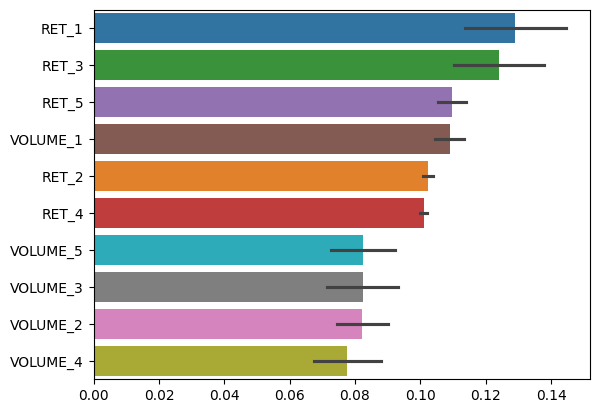

In [71]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Ensemble methods

# Model Evaluation & Comparison

# Output for challenge submission

In [ ]:
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target_feature

submission.to_csv('test.csv', index=True, header=True)

KeyboardInterrupt: 